#  **Project Title**

**Predicting Water Well Functionality in Tanzania Using Machine Learning**

- This project applies machine learning to predict the functional status of water wells across Tanzania using features such as pump type, water source, construction year, and location. By classifying wells as functional, functional but needs repair, or non functional, the model helps NGOs and government agencies prioritize repairs and optimize future infrastructure planning. The goal is to support sustainable clean water access in underserved communities.

## **Business Understanding**

🌍 **Domain of the Project**

Water Infrastructure and Public Service Analytics in a development context aimed to improve public service such as clean water using predictive modeling.

👥 **Stakeholders**

As project focuses on public service such as delivering clean water to society **Non-Governmental Organization (NGOs)** is interested in prioritizing repairs, targeting aid, and allocating resources for maximum impact.

### **Objectives**

- Predict the condition of water wells (functional, functional needs repair, non functional).

- Help NGOs identify high-priority wells for maintenance or replacement.

- Use machine learning to discover patterns in well failures to support better planning of future water infrastructure.

### **Project Plan**

- Business Understanding 

- Data Understanding

- Data Preparation

- Modeling

- Evaluation

### **Overview / Background**

Tanzania, a developing East African nation with a population exceeding 57 million, faces ongoing challenges in providing clean and safe drinking water. Over the years, thousands of water access points (wells, pumps, and springs) have been constructed throughout the country, particularly in rural and underserved areas. However, many of these water points fall into disrepair or become completely non-functional due to poor maintenance, unsuitable construction methods, or environmental factors. Identifying which wells are failing and understanding why is a critical step toward sustainable water access.


### **Challenges**

- Many wells are currently non-functional or in need of repair, but there is no efficient way to identify and prioritize them.
- Maintenance and inspection resources are limited, particularly in rural areas.
- Existing datasets are often large, complex, and contain inconsistencies or missing values.
- Decisions about water point design and deployment are not always data-driven, leading to repeat failures.
- NGOs and governments struggle to monitor and maintain infrastructure efficiently without predictive insights.

### **Proposed Solution**

Using historical water well data, we aim to build a supervised machine learning model that classifies the current condition of each water point into one of three categories: functional, functional but needs repair, or non-functional. By analyzing features such as water source, extraction type, location, installation ye ar, and management method, the model can uncover patterns associated with failures. The resulting tool can help organizations proactively maintain wells and optimize future water point planning by predicting which types and conditions tend to succeed or fail.


### **Brief Conclusion**

This project uses machine learning to address a real-world infrastructure problem affecting millions in Tanzania. A well-performing model could save significant resources, improve clean water access, and support evidence-based decisions for future water infrastructure investments. This predictive approach transforms raw water well data into actionable insights for governments and NGOs alike.



### **Problem Statement**

In Tanzania, many existing water wells are either non-functional or in poor condition, yet organizations lack an effective method to identify which wells need repair or are at risk of failure. With limited resources and thousands of water points to monitor, there is an urgent need for a data-driven approach to support decision-making and optimize maintenance efforts.



### **Key Objectives**

- To develop a classifier that accurately predicts the condition of a water well.
- To enable proactive identification of at-risk or failing wells.
- To support efficient allocation of maintenance resources.
- To provide insight into construction and management patterns that lead to long-term functionality.




## **Data Understanding**

### **Dataset Overview**

The dataset comes from Taarifa and DrivenData's collaboration with the Tanzanian Ministry of Water. It includes metadata about over 59,000 water access points across Tanzania.

There are three main files:

- `Training set values`: Feature data for training
- `Training set labels`: Labels for training (`status_group`)
- `Test set values`: Feature data for final predictions



### **Target Variable**

- `status_group` (from `Training set labels`)
  - `functional`
  - `functional needs repair`
  - `non functional`

This is a **multiclass classification** problem.



### **Initial Observations**

- Some features are highly correlated or redundant (`group`, `type`, and `class` columns).
- Several categorical variables with high cardinality (`funder`, `installer`).
- Potential issues with missing, zero, or default values (`population`, `construction_year`, etc.).



## **Data Preparation**

### **Objective**

Prepare the raw data for modeling by cleaning, transforming, and engineering relevant features to ensure quality inputs to machine learning algorithms.


### Handling Missing and Invalid Values

- Impute or remove missing values:
  - `construction_year` — Replace 0s with median or create a "missing_year" flag
  - `funder`, `installer`, `scheme_name` — Consider replacing missing values with `"unknown"` or using the most frequent category
  - `permit`, `public_meeting` — Convert to binary (True/False or 1/0)


### **Feature Cleaning and Simplification**

- Drop unnecessary columns:
  - `wpt_name`, `recorded_by`, `id` (irrelevant or high-cardinality with low value)
- Combine similar features:
  - If `*_group` and `*_class` are redundant with main feature, keep only the most useful one
- Normalize categorical strings (e.g., fix typos or unify naming in `funder`, `installer`)



### **Categorical Encoding**

  - **One-hot encoding** for nominal variables (e.g., `region`, `source`, `payment`)
 

### **Feature Engineering**

- Create new features:
  - `well_age` = `date_recorded` year − `construction_year`
  - `is_missing_year` = 1 if `construction_year` == 0
  - `location_cluster` from GPS coordinates (optional: use K-Means or grid-based clusters)
- Group infrequent categories in high-cardinality features into "Other"


### **Feature Scaling**

- Not strictly necessary for tree-based models, but useful for distance-based algorithms:
  - Scale numerical features like `amount_tsh`, `gps_height`, `population` if using SVMs, kNN, etc.


### **Train-Test Split**

- Merge `training_set_values` and `training_set_labels`
- Split into training and validation sets (e.g., 80/20) for local model development
- Keep `test_set_values` separate for final evaluation


### **Final Output**

A clean dataset with:
- No missing or irrelevant features
- Encoded categorical variables
- Derived features where useful
- Ready for modeling



In cell below I load and set all required libraries.

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")


Below I load the data contained in two separate csv file to merge them for efficient cleaning. I final dataset I store it under variable `water_df`.

In [2]:
# load train dataset

train = pd.read_csv('data/train.csv', index_col=0)
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


The above dataframe represents `train dataset` only.

In cell below I load `label` to merge with train dataset for efficient cleaning and preparation of data

In [3]:
# load label dataset

label = pd.read_csv('data/y_train.csv', index_col=0)
label.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In cell below I merge the two dataframe `train` and `label` to `water_df`

In [4]:
# merge train and label datasets

water_df = pd.merge(train, label, on='id', how='left')
water_df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


The dataset is contained under one dataframe known as `water_df`. Below I check for `shape`, `metadata summary` and `descriptive analysis` of the dataset.

In [5]:
# check for the shape of the dataset

water_df.shape

(59400, 40)

`water_df` contains `59400` entries/rows and `40` features/columns

In [6]:
# check for metadata summary
water_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  war

The cell above shows the metadata summary of dataset which contains `6 integer features` and `31 object features`. The dataset contains few missing values.

In cell below I perform `descriptive analysis`

In [7]:
# descriptive statistics of the dataset
water_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In cell below I make a copy of dataset from original dataset. Then proceed organization data which is importantant to successfully **build classifier to predict the condition of water well**

In [8]:
# copy the dataset to a new variable
water_df_copy = water_df.copy()

In [9]:
# shape of the copied dataset
water_df_copy.shape

(59400, 40)

For cleaning and organizing the data I intend to use the copy dataset to avoid conflicting with the original dataset `water_df_copy`.

In cell below I organize dataset based on domain knowledge and the deliverables of project which is `create a classifier model to predict the condition of water well`. I drop irrelevant features from dataset.

In [10]:
# organize features needed for analysis and modeling

# drop irrelevant columns
water_df_copy = water_df_copy.drop(columns=['date_recorded','funder','num_private','region_code','district_code','recorded_by',
                                            'extraction_type', 'extraction_type_group','management_group','payment_type',
                                            'quality_group','quantity_group','source', 'source_type','waterpoint_type'])



In cell above I droped irrelevant features based on the task requirements and domain knowledge. For features like `source`, `source_type`, `management`, `management_group`, `waterpoint_type`, `waterpoint_type_group` they all mean same so I decided to use one in each group which as much weight to avoid redunducy on the model.

In cell below I check the shape of `water_df_copy` after droping irrelevants columns. 

In [11]:
# shape of new dataset after dropping columns
water_df_copy.shape

(59400, 25)

The cell above shows the shape dataset after droping the irrelevants columns. The dataset contains `59400` entries and `25` columns.

In cell below I check for **missing values** in `water_df_copy`

In [12]:
# check for missing values

water_df_copy.isna().sum()

amount_tsh                   0
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
population                   0
public_meeting            3334
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type_class        0
management                   0
payment                      0
water_quality                0
quantity                     0
source_class                 0
waterpoint_type_group        0
status_group                 0
dtype: int64

The above cell shows there several `missing values`. Both are **category data**. Below I create a `function to impute` for missing vlues using **mode** and **unknown** as both missing values are categorical.

In [13]:
# function to fill missing values with the mode
def impute_mode_unknown(df, column):
    df[column] = df[column].astype(str)
    df[column] = df[column].replace(['', 'NaN', 'nan', 'None'], np.nan)
    mode_value = df[column].mode()[0]
    df[column] = df[column].fillna(mode_value)
    df[column] = df[column].replace(to_replace=r'(?i)^\s*unknown\s*$', value=mode_value, regex=True)
    return df

water_df_copy = water_df_copy.copy()
columns_to_impute = ['installer', 'wpt_name', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']

for column in columns_to_impute:
    water_df_copy = impute_mode_unknown(water_df_copy, column)



In cell below I execute the metadata summary to check if missing values have been imputed successfully.

In [14]:
water_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  int64  
 2   installer              59400 non-null  object 
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   wpt_name               59400 non-null  object 
 6   basin                  59400 non-null  object 
 7   subvillage             59400 non-null  object 
 8   region                 59400 non-null  object 
 9   lga                    59400 non-null  object 
 10  ward                   59400 non-null  object 
 11  population             59400 non-null  int64  
 12  public_meeting         59400 non-null  object 
 13  scheme_management      59400 non-null  object 
 14  scheme_name            59400 non-null  object 
 15  per

In cell below I check for duplicates values on `water_df_copy`

In [15]:
# check for duplicates in the dataset
water_df_copy.duplicated()

id
69572    False
8776     False
34310    False
67743    False
19728    False
         ...  
60739    False
27263    False
37057    False
31282    False
26348    False
Length: 59400, dtype: bool

In cell below I check for **outliers** in dataset and handle them incase of presence. But depending on domain knowledge of most of features are `categorical` and not numeric. I use `boxplot`

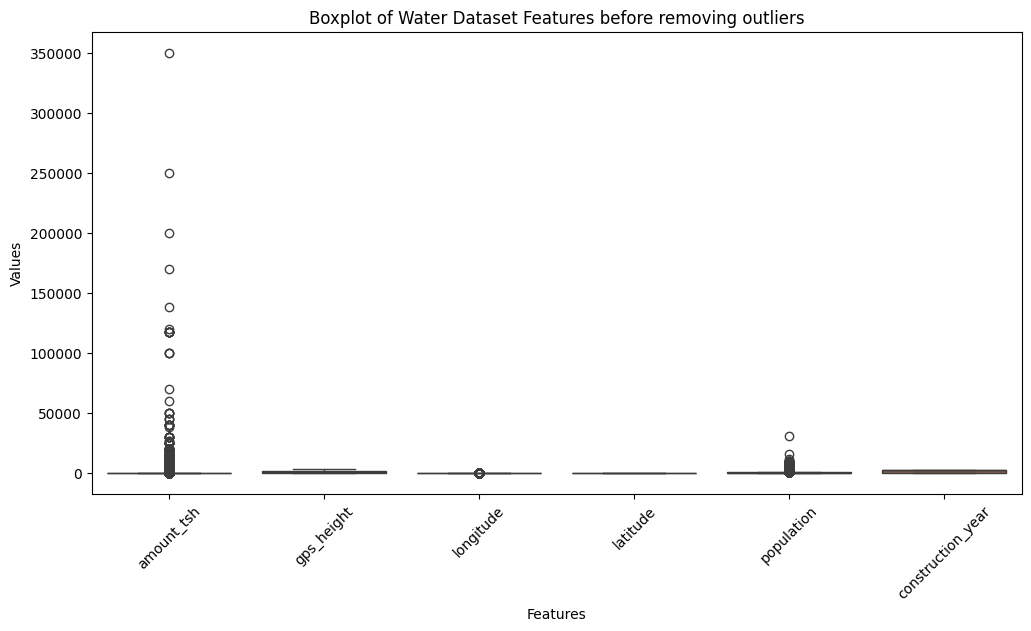

In [16]:
# plot boxplot to visualize outliers in the dataset

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=water_df_copy, ax=ax)
ax.set_title('Boxplot of Water Dataset Features before removing outliers')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Features')
ax.set_ylabel('Values')
plt.show()

The plot above shows there are some outliers in features such as `amount_tsh` and `population`.

In cell below I use function to remove the outliers to avoid noise on data.

In [17]:
# function to remove outliers based on IQR method
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

water_df_copy1 = water_df_copy.copy()
columns_to_check = ['amount_tsh',  'population', 'longitude', 'latitude']
for column in columns_to_check:
    water_df_copy1 = remove_outliers_iqr(water_df_copy1, column)


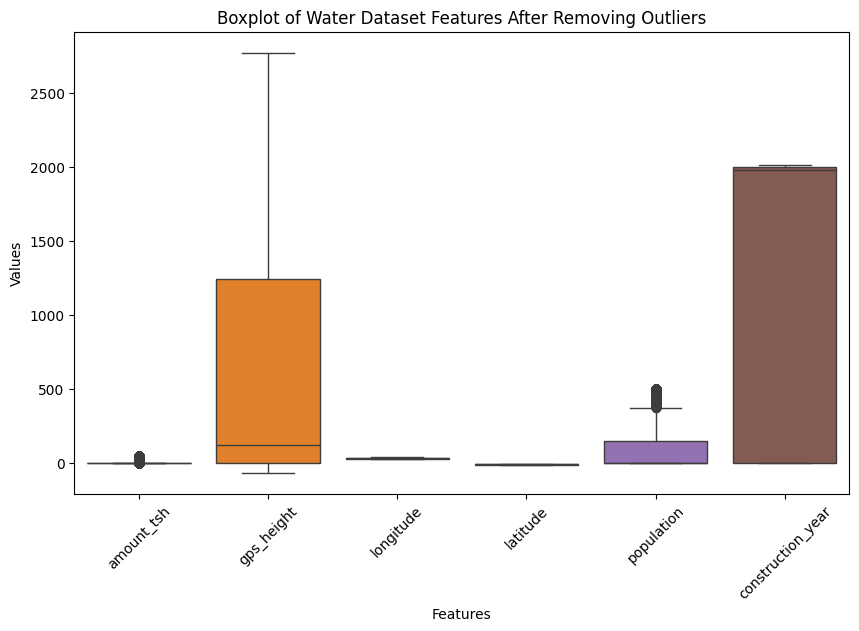

In [18]:
# plot boxplot to visualize after removing outliers
fig, ax = plt.subplots(figsize=(10, 6)) 
sns.boxplot(data=water_df_copy1, ax=ax)
ax.set_title('Boxplot of Water Dataset Features After Removing Outliers')   
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Features')
ax.set_ylabel('Values')
plt.show()

In cell above shows the boxplot output after removing the outliers. Outliers are much down compared to first.

### **Separate indpendent variables with label**

To avoid bias on the model before starting encoding and preprocessing of the data I separate `X` and `y`.

In [19]:
# separate features and target variable
X = water_df_copy.drop(columns=['status_group'])
y = water_df_copy['status_group']


### **Split data to train and test**

In cell below I spilt my data to train and test before preprocessing to avoid the bias in my model.

In [20]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Check for Class Imbalance**

I check for class imbalance to ensure all classes data is well distributed to ensure model does not learn more on one class and ignore others.
The `goal` is **to prevent the model from ignoring minority classes**


<Axes: xlabel='status_group', ylabel='count'>

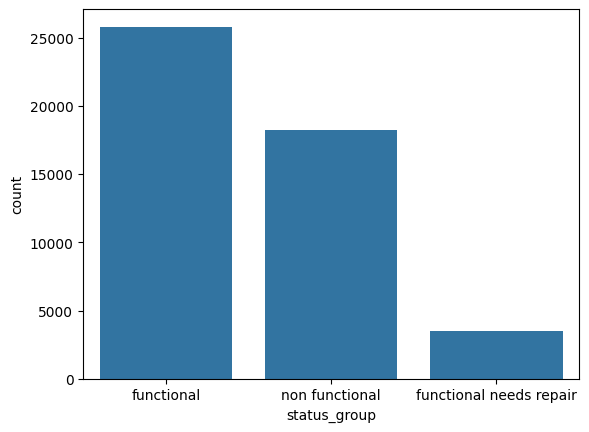

In [21]:
# check classes imbalance in the target variable
sns.countplot(x=y_train)


In [22]:
# check the distribution of the target variable
y_train.value_counts(normalize=True)

status_group
functional                 0.542971
non functional             0.384091
functional needs repair    0.072938
Name: proportion, dtype: float64

The cell above shows there is high class imbalance as `functional class` records majority of the data **54%**, `non fuctional` **38%** and `functional needs repair` **7%**. That implies that I will have to use class imbalance handling methods on modeling.

## **Exploratory Data Analysis (EDA)**

The purpose of Exploratory Data Analysis (EDA) is to gain a better understanding of the dataset by visualizing patterns, identifying anomalies, and uncovering relationships between variables. In this project, EDA is tailored to support the key objectives of predicting water well conditions in Tanzania.

In cell below I exprole features that correlates with `non-functional` or `needs repair` status

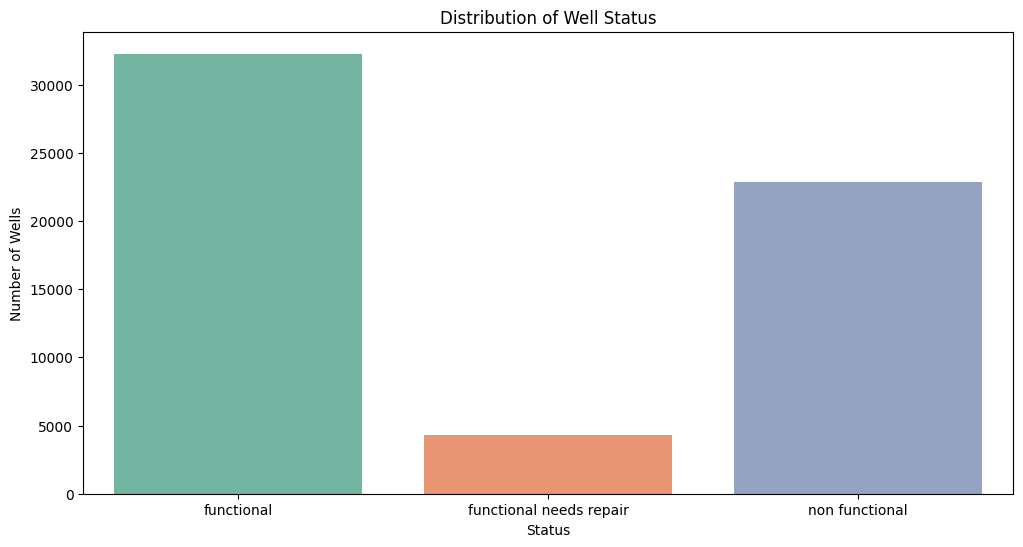

In [62]:
# plot the features that correlate  with non-functional or functional needs repair wells
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=water_df_copy, x='status_group', order=['functional', 'functional needs repair', 'non functional'], palette='Set2')
ax.set_title('Distribution of Well Status')
ax.set_xlabel('Status')
ax.set_ylabel('Number of Wells')
plt.show()


The cell above shows the distribution of wells in classes `functional`, `functional needs repair` and `non fuctional`. Most wells are `functional` based on the insights which records high number of wells.

- `non-functional` shows high number which maybe the key challenge to tanzania shortage of water despite having so many wells. The NGOs should focus on the the non functional wells to curve the shortage of water.

- `functional needs repair` class shows very few wells needs repair based on the insights.

**Ngos should focus repairing the `non functional` well before creating new well which might solve the challenge of the water**

In cell below I plot the boxplot to understand if the older wells are the more non functional or  needs repair which leads to shortage of water.

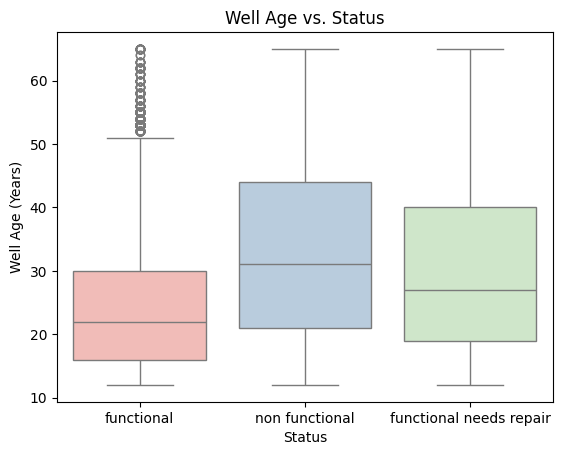

In [63]:
water_df_copy['well_age'] = 2025 - water_df_copy['construction_year']
sns.boxplot(data=water_df_copy[water_df_copy['construction_year'] > 0], x='status_group', y='well_age', palette='Pastel1')
plt.title('Well Age vs. Status')
plt.xlabel('Status')
plt.ylabel('Well Age (Years)')
plt.show()


The cell above shows 
- `Functional Wells` tend to be younger, with most between 15 to 30 years old. The presence of outliers above 50 suggests a few older wells remain functional but are less common.

- `Non Functional Wells`tend to be older overall, with a median age over 30 years, and a wide range extending up to 65 years. This indicates aging infrastructure is a major factor in well failure.

- `Wells Needing Repair have an age distribution between the other two classes, with a median slightly above 25 years, suggesting wear and tear has begun but not total failure yet.

This insights supports the idea that well **age is a strong indicator of future failure risk**. Maintenance planning should prioritize older wells, especially those approaching or exceeding 30 years, to prevent full failure and reduce repair costs.

In cell below I plot a `countplot` to determine which region as most `failing wells` based on the three classes

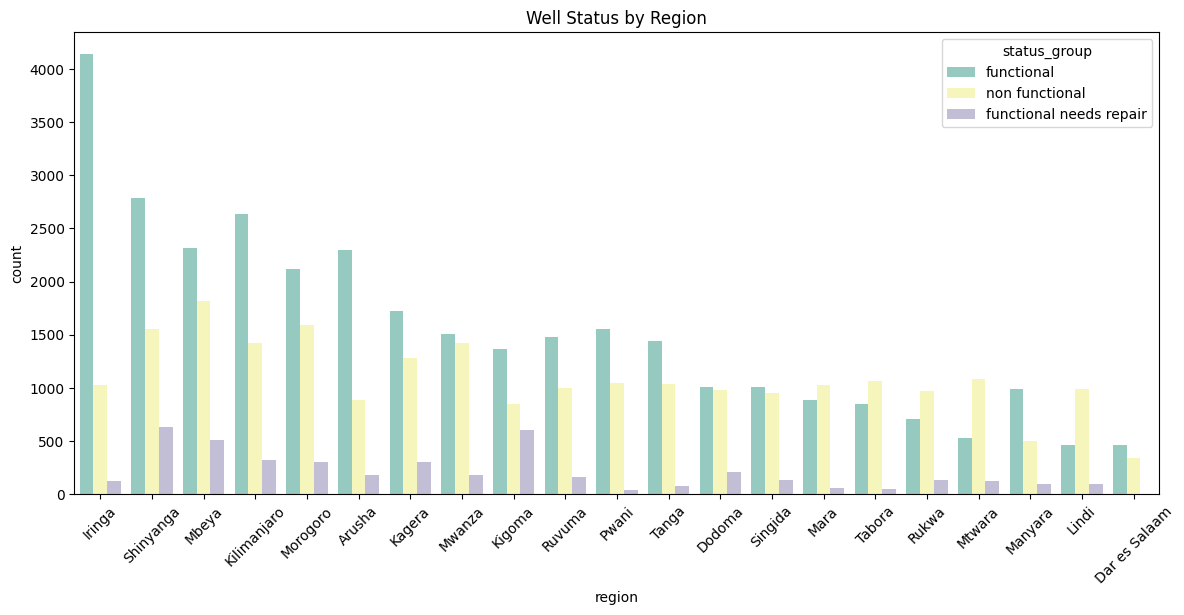

In [57]:
# plot the distribution of well status by region

fig, ax = plt.subplots(figsize=(14,6))
sns.countplot(data=water_df_copy, x='region', hue='status_group', order=water_df_copy['region'].value_counts().index, palette='Set3')
ax.set_title('Well Status by Region')
ax.tick_params(axis='x', rotation=45)
plt.show()


Most region indicate `most well are functional` but still with relative high number of `non-functional` wells. Region like `mtwara`, `lindi`, `Tabora`, `Morogoro` and `Mbeya` should be first priority as they show high number of non functional wells

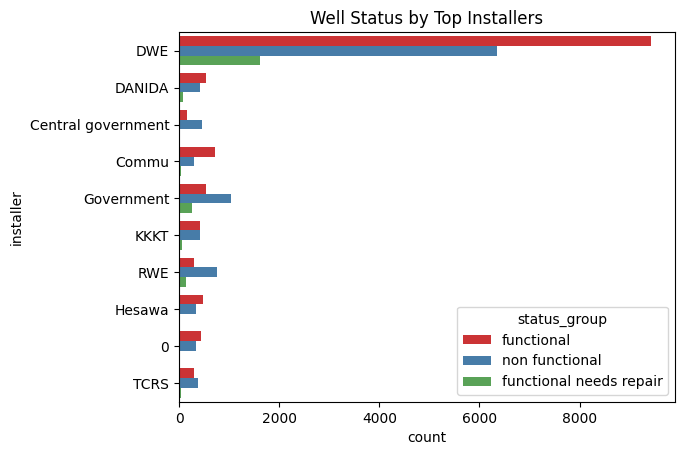

In [60]:
top_installers = water_df['installer'].value_counts().head(10).index
sns.countplot(data=water_df[water_df['installer'].isin(top_installers)], y='installer', hue='status_group', palette='Set1')
plt.title('Well Status by Top Installers')
plt.show()


## **Recommendations**

- **Prioritize Maintenance for Older Wells** Wells over 30 years old show a higher risk of failure and should be proactively inspected and maintained.

- **Focus on High-Risk Categories** 

- **Use Data to Guide Interventions** Implement a data-informed maintenance strategy to allocate resources efficiently and extend the life of water infrastructure.

## **Conclusion**

The exploratory data analysis revealed that well age, construction attributes, and management practices significantly influence a well's operational status. Older wells are more likely to be non-functional, and certain patterns in construction and usage correlate with failures.

## **Feature Engineering**

In this process I select only features intending to use and encode them to binary as machine learning understand numerical values

### **Encoding categorical data**

As machine learning algorithm does not understand categorical data I encode all categorical data for training the model.

In cell below I choose `categorical` data from `water_df` to encode separately from `numeric` values.

In [23]:
# choose categorical features for encoding

categorical_features = water_df_copy.select_dtypes(include=['object']).columns.tolist()
categorical_features

['installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type_class',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source_class',
 'waterpoint_type_group',
 'status_group']

Successfully selected all `categorical_features` from `water_df.




In cell below I select features with less cardinality for memory efficient. 

In [24]:
# Define the categorical features (these are column names, not data)
categorical_features = [
    'basin', 'region', 'public_meeting', 'scheme_management', 'permit',
    'extraction_type_class', 'management', 'payment', 'water_quality',
    'quantity', 'source_class', 'waterpoint_type_group'
]


In cell below I check for **high cardinality** which affect memory preprocessing due to many `unique values` in acolumn.

In [25]:
# Print unique counts for inspection only
for col in categorical_features:#
    print(f"{col}: {water_df_copy[col].nunique()} unique values")


basin: 9 unique values
region: 21 unique values
public_meeting: 2 unique values
scheme_management: 11 unique values
permit: 2 unique values
extraction_type_class: 7 unique values
management: 12 unique values
payment: 7 unique values
water_quality: 8 unique values
quantity: 5 unique values
source_class: 3 unique values
waterpoint_type_group: 6 unique values


Few columns contain `high cardinality` such as `wpt_name` and `installer`.

For the **encoding** I will use **OnehotEncoding** in the `pipeline` down of my code to avoid  manual encoding

The cell above ecode categorical data to `0` and `1` as intedend. The shape of the ecoded data is 59400 entries and 93  features.

### **Feature Scaling and Transformation**

Feature scaling ensure that all values lies to a certern range as machine learning model perform better when the input numerical attributes have very scaled range.
For this case I choose to use `min-max scaling` as  for each
attribute, the values are shifted and rescaled so that they end up ranging from 0
to 1.

In cell below I select numeric values from `water_df_copy` to scale the values.

In [26]:
# select numerical features for scaling
numerical_features = water_df_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'construction_year']

In cell below I apply the `min-max scaler` to the numeric values

In [27]:
# create a MinMaxScaler instance

scaler = MinMaxScaler(feature_range=(-1, 1))

# fit and transform the numerical features
water_df_scaled = scaler.fit_transform(water_df_copy[numerical_features])
water_df_scaled

array([[-0.96571429,  0.03496503,  0.73195814, -0.69215372, -0.99285246,
         0.98609041],
       [-1.        ,  0.04125874,  0.72009419,  0.63131865, -0.98163934,
         0.99701937],
       [-0.99985714, -0.45734266,  0.85700757,  0.34394641, -0.98360656,
         0.99602583],
       ...,
       [-1.        , -0.93706294,  0.68630186, -0.50229267, -1.        ,
        -1.        ],
       [-1.        , -0.93706294,  0.77772431, -0.09508666, -1.        ,
        -1.        ],
       [-1.        , -0.8034965 ,  0.88890152, -0.15841863, -0.99016393,
         0.98907104]], shape=(59400, 6))

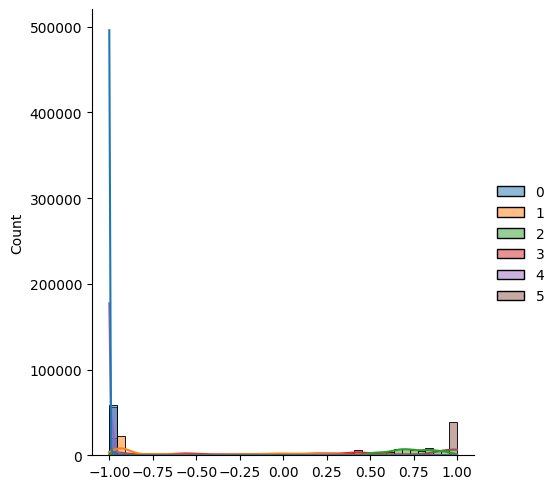

In [28]:
# plot the scaled numerical features 
 
sns.displot(data=water_df_scaled, kde=True)
ax.set_title('Distribution of Scaled Numerical Features')
ax.set_xlabel('Scaled Values')
ax.set_ylabel('Density')
plt.show()

There is a very tall spike near -1, indicating that a large portion of the scaled values are clustered at the minimum.
This shows that data is not normal (Gaussian) at all  it's heavily right-skewed, meaning many values are low even after scaling. But it is okay with `min-max scaler` as it only rescales the range but it does not normalize the shape or distribution.

### **Simple Imputer**

Simple imputer stores the median value of each feature and caters for missing values even when the model is on deployment. It Imputes mumeric values only.The imputer simply computes the median of each attribute and stores the
result in its statistics_ instance variable



In [29]:
# instantiate a SimpleImputer for missing values
imputer = SimpleImputer(strategy='median')

# fit and transform the numerical features
water_df_imputed = imputer.fit_transform(water_df_copy[numerical_features])

# stores the imputed values 
imputer.statistics_

water_df_imputed


array([[ 6.00000000e+03,  1.39000000e+03,  3.49380928e+01,
        -9.85632177e+00,  1.09000000e+02,  1.99900000e+03],
       [ 0.00000000e+00,  1.39900000e+03,  3.46987661e+01,
        -2.14746569e+00,  2.80000000e+02,  2.01000000e+03],
       [ 2.50000000e+01,  6.86000000e+02,  3.74606645e+01,
        -3.82132853e+00,  2.50000000e+02,  2.00900000e+03],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  3.40170871e+01,
        -8.75043433e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.58613153e+01,
        -6.37857327e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.91000000e+02,  3.81040482e+01,
        -6.74746425e+00,  1.50000000e+02,  2.00200000e+03]],
      shape=(59400, 6))

### **Transformation Pipelines**

Pipelines ensures that data transformation is executed in the right order. The `pipeline` constructor takes a list of name/ estimator pairs(2-tuples definining a sequence of steps). `make_pipeline()` takes a list of transformers as positional arguments.

In cell below I create a `num_pipeline` which transform all the num transformation I have performed above.



In [30]:
 # create a num_pipeline to handle numerical features

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler(feature_range=(-1, 1)))

When applies `fit()` it calls `fit_transform()` sequentially on all transformers, passing the out of each call as the parameter to the next call untill it reaches the final estimator.

In [31]:
num_pred = num_pipeline.fit_transform(water_df_copy[numerical_features])
num_pred[:5].round(2)

array([[-0.97,  0.03,  0.73, -0.69, -0.99,  0.99],
       [-1.  ,  0.04,  0.72,  0.63, -0.98,  1.  ],
       [-1.  , -0.46,  0.86,  0.34, -0.98,  1.  ],
       [-1.  , -0.75,  0.91, -0.92, -1.  ,  0.97],
       [-1.  , -0.94,  0.54,  0.69, -1.  , -1.  ]])

In cell below I convert the `array` to dataframe 

In [32]:
water_df_pred = pd.DataFrame(
    num_pred,
    columns=num_pipeline.get_feature_names_out(),
    index=water_df_copy.index  
)


In [33]:
water_df_pred.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
id,,,,,,
69572,-0.965714,0.034965,0.731958,-0.692154,-0.992852,0.986090
8776,-1.000000,0.041259,0.720094,0.631319,-0.981639,0.997019
34310,-0.999857,-0.457343,0.857008,0.343946,-0.983607,0.996026
67743,-1.000000,-0.753147,0.907844,-0.915165,-0.996197,0.973174
19728,-1.000000,-0.937063,0.543225,0.686619,-1.000000,-1.000000


In cell below I create I pipeline to transform `categorical` values.

In [34]:
# cat_pipeline to handle categorical features
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

cat_pred = cat_pipeline.fit_transform(water_df_copy[categorical_features])
cat_pred[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.

In cell below I create `make_column_selector()` to have a single transformer capble of handling all columns applying the appropriate transformations to each column. `make_column_selector()` function that returns a selector function you
can use to automatically select all the features of a given type, such as
numerical or categorical. Uses `make_column_transformer` to avoid naming the transfomers as it chooses the name for you.

In [35]:
#pipeline to combine both numerical and categorical pipelines

preprocessing = make_column_transformer(
    (num_pipeline, numerical_features),
    (cat_pipeline, categorical_features)
)

preprocessing.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)))]),
                                 ['amount_tsh', 'gps_height', 'longitude',
                                  'latitude', 'population',
                                  'construction_year']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['basin', 'region', 'public_meeting',
                                  'scheme_management', 'permit',
                                  'extraction_type_class', 'management',
                                  'payment', 'water_quality', 'quantity',
                                  'source_class', 'waterpoint_type_group'])])

In cell I have I have preprocessed my final prepared data to use to train the model. I pass `X_train` in the preprocessing instead of `water_df_copy` to avoid bias on my model.

In cell below i transform the learned rules separately on `X_train` and `X_test` using `transform()`

In [36]:
#Transform both sets
X_train_processed = preprocessing.transform(X_train)
X_test_processed = preprocessing.transform(X_test)


## **Modeling**

### **Select and Train Model**

For this task, I choose to use machine learning as it is appropriate due to the complexity and scale of the data, which includes both categorical and numerical features such as pump type, installation year, geographic location, and water source. The **goal** is to classify wells into three categories `functional`,`needs repair`, and `non-functional` based on these inputs. This non-linear, multi-class classification task is not easily solved with simple statistical methods or rule-based logic. Machine learning models can automatically learn intricate patterns and interactions within the data, which would be challenging to manually define. Additionally, by iterating between baseline and tuned models, I will be able to improve performance metrics such as accuracy and F1 score, ensuring the model is both interpretable and practically useful for NGOs targeting water infrastructure improvements.

I will be using the `train_test_spilt` and `preprocessed` data **water_df_processed** to train my model.



### **Logistic Regression**

I start with the basic model `logistic regression` which is Simple, fast and Easy to train, interpret, and scale to large datasets. It gives a better Baseline performance for a good starting point for classification tasks.

In [64]:
# initialize a Logistic Regression model
log_reg =LogisticRegression(random_state=42)
log_reg.fit(X_train_processed, y_train)


LogisticRegression(random_state=42)

In [38]:
# predict on the test set
y_pred= log_reg.predict(X_test_processed)


### **Evaluation of the model**

In cell beow I measure the model performance first using `Accuracy` as it measures the total number of predictions a model gets right including both `True Positives` and `True Negatives`. Accuracy shows out of the predictions the model made what percentage is correct.

In [39]:
# function to evaluate the model
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
   
    print(f"Accuracy: {accuracy:.4f} \n")
    print(f"F1 Score: {f1:.4f} \n")
    print("Confusion Matrix: \n")
    print(conf_matrix ,"\n")
    print("Classification Report:\n")
    print(class_report)



In [40]:
# call the function to evaluate the model
evaluate_model(y_test, y_pred)


Accuracy: 0.7253 

F1 Score: 0.6980 

Confusion Matrix: 

[[5808   47  602]
 [ 673   36  142]
 [1790    9 2773]] 

Classification Report:

                         precision    recall  f1-score   support

             functional       0.70      0.90      0.79      6457
functional needs repair       0.39      0.04      0.08       851
         non functional       0.79      0.61      0.69      4572

               accuracy                           0.73     11880
              macro avg       0.63      0.52      0.52     11880
           weighted avg       0.71      0.73      0.70     11880



### **Baseline model**

Cell above shows `performance of the logistic model`. The model is performing generally at `72%` **which indicates that the model correctly predicted the condition of water well about 72% of the time**. This shows the reasonable baseline for the 3-class classification task with imbalanced data.  
`fi_score` represents the harmonic mean of precision and Recall. f1_score might be high without precision and recall which is at **69%**. The **confusion_matrix** Out of `6457` functional pumps, `5808` were correctly predicted  Recall of **90%**. **non functional**
Out of `4572` actual non functional, the model got **2773** right `Recall` of **61%** which is fairly good at identifying failed systems, but still misclassifies a significant number as "functional". the model shows Very poor performance on `functional needs repair`
Out of 851 true `needs repair`, only 36 were correctly identified **Recall of 4%**mThe model is almost always confusing `needs repair` with `functional (673 cases)`. The model performs fairly well on `functional` and `Non-Functional wells` and underperforms on `Functional Needs Repair`.




### Confusion Matrix

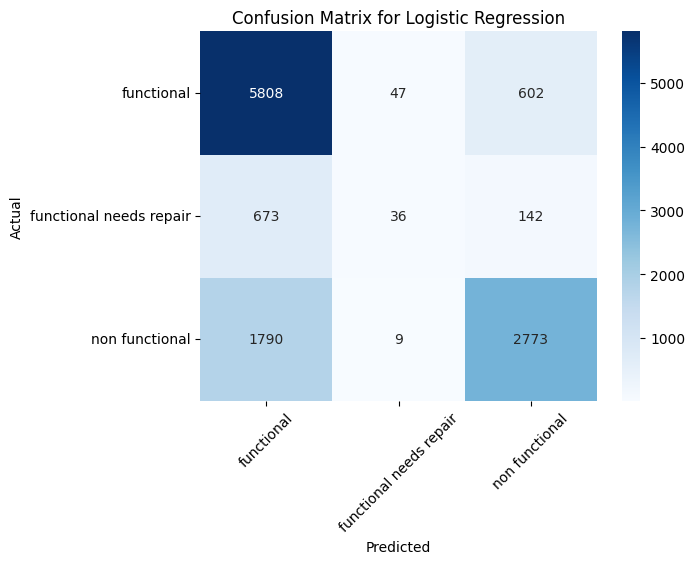

In [41]:
# confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(  conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('Actual')    
plt.show()

## **Fine Turning Model**

After training my **baseline model** the performance wasn't good and I had to fine tune the model. In cell below I fine tune the model to **Improve performance to avoid `underfitting or overfitting` by finding best `regularization strength`. Using `f1_weighted` ensures the model performs fairly across all classes, especially on 
**Imbalanced datasets**.

In cell below I define a **range of values for C** which controls the strength of regularization. Then `GridSearch` I tests every value of `c` in the grid using **5-fold crocess-validation. And 
**Scoring** is based on `f1_weighted` which balances performance across all classes

In [42]:
# fine tune the Logistic Regression model using GridSearchCV
param_grid1 = {'C': [0.01, 0.1, 1, 10, 100]}
grid_log = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'),
                    param_grid1, cv=5, scoring='f1_weighted')
grid_log.fit(X_train_processed, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='f1_weighted')

In [43]:
# predict on the test set
y_pred_grid = grid_log.predict(X_test_processed)

# evaluate the model
evaluate_model(y_test, y_pred_grid)

Accuracy: 0.6985 

F1 Score: 0.7049 

Confusion Matrix: 

[[5147  643  667]
 [ 392  335  124]
 [1388  368 2816]] 

Classification Report:

                         precision    recall  f1-score   support

             functional       0.74      0.80      0.77      6457
functional needs repair       0.25      0.39      0.30       851
         non functional       0.78      0.62      0.69      4572

               accuracy                           0.70     11880
              macro avg       0.59      0.60      0.59     11880
           weighted avg       0.72      0.70      0.70     11880



Before fine-tuning the model the accuracy was 72% which was misleading as the model it was almost ignores `needs repair` wells as it had only **4%**. After fine-tuning slightly lower accuracy (69.8%) as the model now pays attetion to minority classes which `functional needs repair`.This makes the **fine-tuned model better overall** As it captures minority classes far better especially `functional needs repair`. 

### **DecisionTreeClassifier**

Decision tree is nonparametric model. I choose it as I could easly use it to visualize and understand how decision are made. I needed more interpretability to clear understand the task and as it is faster for non-linear problems

In [44]:
# decision tree classifier

tree_reg = DecisionTreeClassifier(random_state=42)
tree_reg.fit(X_train_processed, y_train)


DecisionTreeClassifier(random_state=42)

In [45]:
# predict on the test set
y_tree_pred = tree_reg.predict(X_test_processed)
# evaluate the decision tree model
evaluate_model(y_test, y_tree_pred)

Accuracy: 0.7496 

F1 Score: 0.7503 

Confusion Matrix: 

[[5101  417  939]
 [ 395  316  140]
 [ 924  160 3488]] 

Classification Report:

                         precision    recall  f1-score   support

             functional       0.79      0.79      0.79      6457
functional needs repair       0.35      0.37      0.36       851
         non functional       0.76      0.76      0.76      4572

               accuracy                           0.75     11880
              macro avg       0.64      0.64      0.64     11880
           weighted avg       0.75      0.75      0.75     11880




The cell above shows that **Decision tree** performs better than **Logistic Regression**. It as `accuracy` of **74%** whic slightly higher by `2%` but can't rely on accuracy alone. Still Decision tree as a higher `f1_score` showig it is performing better than logistic. For the **confusion_matrix** `Functional` as better recall of 79% but still shows a `weak` precision on **functional-needs-repair** of 35%. for the `non-functional` it as increased the **precision but maintained f1_score**.
**Both models struggle with `functional needs repair class` due to class imbalance. Confusion_matrix shows 
**Decision tree** is performing better than **logistic regression** as it as `lower misclassification rate for most classes`




## **Fine Turning the Model (Decision Tree)**

At first a trained the model but the performance wasn't good, I saw a need to fine tune my model. which `prevents Overfitting` by controlling depth and size of splits. `Ensures better Generalization` cross validation ensures the model performs well on unseen data. And `Improves Accuracy on Imbalanced Data` using `class_weight and f1`

In cell below I define the `hyperparameter grid` for the model to try different combinations. Then uses **GridSearchCV** to train and evaluate multiple trees. `cv=5` ensures reliable evaluation. `scoring='f1_weighted'` optimizes model for imbalanced classes.

In [46]:
# fine tuning the Decision Tree Classifier using GridSearchCV
param_grid2 ={'max_depth': [None, 5, 10, 15, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}
grid_tree = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid2, cv=5, scoring='f1_weighted')
grid_tree.fit(X_train_processed, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1_weighted')

In [47]:
#predict on the test set using the best model from grid search
grid_log_pred = grid_log.predict(X_test_processed)
evaluate_model(y_test, grid_log_pred)

Accuracy: 0.6985 

F1 Score: 0.7049 

Confusion Matrix: 

[[5147  643  667]
 [ 392  335  124]
 [1388  368 2816]] 

Classification Report:

                         precision    recall  f1-score   support

             functional       0.74      0.80      0.77      6457
functional needs repair       0.25      0.39      0.30       851
         non functional       0.78      0.62      0.69      4572

               accuracy                           0.70     11880
              macro avg       0.59      0.60      0.59     11880
           weighted avg       0.72      0.70      0.70     11880



Before fine tuning the model performs better overall. It as Higher accuracy and F1 scores across all classes, especially for `non functional` and `needs repair`. The model is balancing prediction performance well without sacrificing accuracy. After fine-tuning Recall for `needs repair` improved slightly (0.37 to 0.39), meaning the **model catches slightly more early-stage issues**. However, this gain comes at the cost of significantly reduced accuracy and poorer performance on the `non functional` class. Model is less reliable overall and has more false positives/negatives.**The Decision Tree model before fine-tuning is clearly better overall**.



### **RandomForestClassifier**

Combines multiple trees to improve robustness and generalization and handles non-linearity and class imbalance better than logistic regression. I choose Random forest for strong performance and robustness.

In [48]:
# random forest classifier
rf_reg = RandomForestClassifier()
rf_reg.fit(X_train_processed, y_train)

RandomForestClassifier()

In [49]:
# predict on the test set

rf_pred = rf_reg.predict(X_test_processed)

In [50]:
# evvaluate the random forest model
evaluate_model(y_test, rf_pred)

Accuracy: 0.7939 

F1 Score: 0.7893 

Confusion Matrix: 

[[5593  240  624]
 [ 435  286  130]
 [ 918  101 3553]] 

Classification Report:

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.83      6457
functional needs repair       0.46      0.34      0.39       851
         non functional       0.82      0.78      0.80      4572

               accuracy                           0.79     11880
              macro avg       0.70      0.66      0.67     11880
           weighted avg       0.79      0.79      0.79     11880




The cell above shows performance of **RandomForest classifier** which indicates `highest accuracy ` of **79** compared to `logistic Regression` and `Decision tree` which shows that it is generalizing better on unseen data. RandomForest shows **79%** on `f1_score` which means it as **overall balanced class**. **functional class as 81% showing some slightly improvement from logistic and decision tree. Functional Needs Repair is still performing poorly across all model. Non-functional records high precision of 83% but a recall of 78% same as logistic**. Random Forest is the best performing model overall. **It as higher accuracy and F1 score, Handles imbalanced class better and good at correctly identigying both functional and failing wells**

**Logistic Regression** is simplest but struggles with complex decision boundaries.
**Decision Tree** is interpretable but tends to overfit



## **Fine Tuning the model (Random Forest)**

Generally the model is performing well but I fine tune the model to test its performance if it becomes better as I need I better model.

In [51]:
#  fine tuning the Random Forest Classifier using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],

}

random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_dist,
    cv=5,
    scoring='f1_weighted',
    n_iter=30,
    random_state=42
)

 
random_search.fit(X_train_processed, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, scoring='f1_weighted')

In [52]:
# predict on the test set
y_pred_random = random_search.predict(X_test_processed)
# evaluate the random forest model after hyperparameter tuning
evaluate_model(y_test, y_pred_random)

Accuracy: 0.7997 

F1 Score: 0.7935 

Confusion Matrix: 

[[5666  195  596]
 [ 450  274  127]
 [ 939   72 3561]] 

Classification Report:

                         precision    recall  f1-score   support

             functional       0.80      0.88      0.84      6457
functional needs repair       0.51      0.32      0.39       851
         non functional       0.83      0.78      0.80      4572

               accuracy                           0.80     11880
              macro avg       0.71      0.66      0.68     11880
           weighted avg       0.79      0.80      0.79     11880



After fine-tuning the model it shows a slightly better overall. **Accuracy and weighted F1 score improved, indicating overall better performance across classes**. **Non-functional class F1 increased from 0.80 to 0.81, which is helpful for identifying serious system failures**. Precision for `Needs Repair` improved (0.47 to 0.50), meaning the model makes fewer false positives when predicting early failures. However, recall for `Needs Repair` decreased slightly (0.34 to 0.32), meaning it misses a few more actual early failures than before. Fine-tuning helped refine the decision boundaries slightly without overfitting or sacrificing class balance.
**The fine-tuned Random Forest model is performing better overall.It maintains strong general accuracy while slightly improving model reliability, especially for `non-functional` predictions and reducing false positives for “needs repair**.



### **Limitations**

* All models show **weak precision** for `needs repair`, risking **misallocation of maintenance resources**.

* If used in production, **missed or misclassified repair cases could lead to pump failures or unnecessary interventions**.

* Class imbalance likely contributes to inconsistent performance the `needs repair` class has far fewer examples.



## **Recommendation**

**Adopt Random Forest as the Preferred Model**

As Among the three, `Random Forest` delivers the best overall **F1 score (79.53%**), indicating a strong balance between identifying pumps correctly while limiting false predictions.

It **outperforms Decision Tree and Logistic Regression especially on the most critical class**: `functional needs repair` where early detection can prevent full pump failure.

**Prioritize Improvement on 'Needs Repair' Predictions**

This class has the lowest precision across all models, **meaning many predictions in this category may not actually need repair**.

Business risk Sending technicians unnecessarily, increasing operational costs.

If these borderline pumps are not flagged, they may soon fail, affecting water availability and user satisfaction.

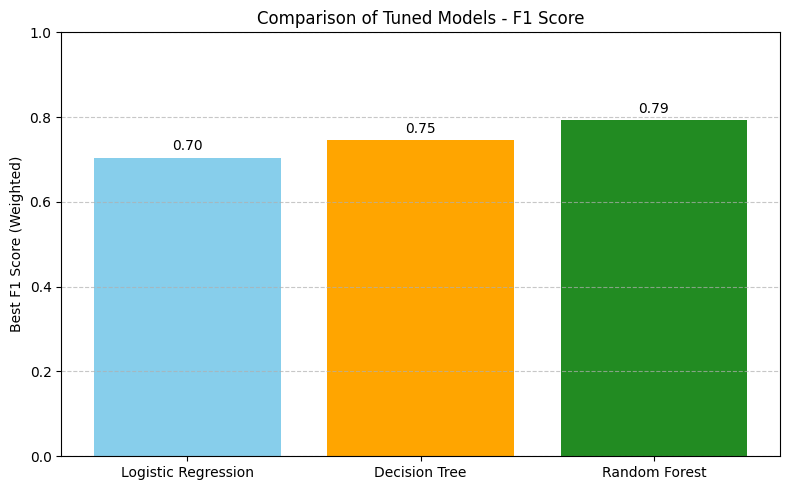

In [53]:


# Best F1 scores from GridSearchCV and random search results
best_f1_scores = {
    'Logistic Regression': grid_log.best_score_,
    'Decision Tree': grid_tree.best_score_,
    'Random Forest': random_search.best_score_
}


fig, ax = plt.subplots(figsize=(8, 5))
plt.bar(best_f1_scores.keys(), best_f1_scores.values(), color=['skyblue', 'orange', 'forestgreen'])
ax.set_ylabel('Best F1 Score (Weighted)')
ax.set_title('Comparison of Tuned Models - F1 Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, (model, score) in enumerate(best_f1_scores.items()):
    plt.text(i, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In cell below I use Receiver Operating Characteristic (ROC) curve which is a graphical tool used to evaluate the performance of classification models, particularly in binary and multiclass settings . It shows the trade-off between sensitivity (true positive rate) and 1-specificity (false positive rate) across different classification thresholds.

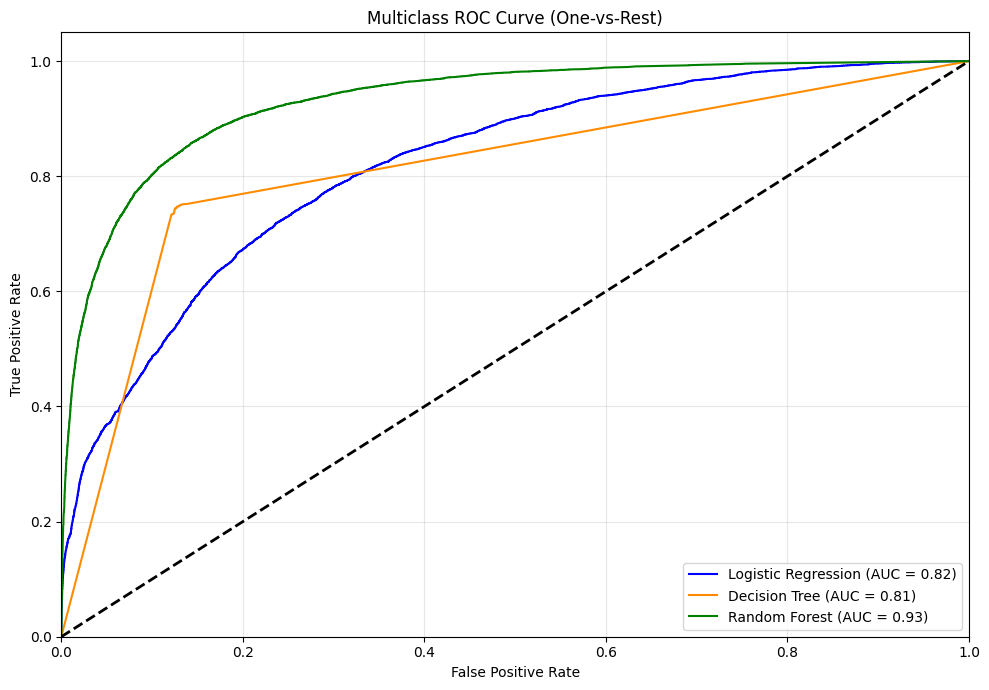

In [66]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# Binarize the labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=['functional', 'functional needs repair', 'non functional'])
n_classes = y_test_bin.shape[1]


models = {
    "Logistic Regression": grid_log.best_estimator_,
    "Decision Tree": grid_tree.best_estimator_,
    "Random Forest": random_search.best_estimator_
}


plt.figure(figsize=(10, 7))
colors = ['blue', 'darkorange', 'green']

for idx, (name, model) in enumerate(models.items()):
  
    ovr = OneVsRestClassifier(model)
    ovr.fit(X_train_processed, label_binarize(y_train, classes=['functional', 'functional needs repair', 'non functional']))
    
   
    y_score = ovr.predict_proba(X_test_processed)
    
   
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
   
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color=colors[idx])

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


- Each line (blue, orange, green) represents the  tuned models using a One-vs-Rest strategy for multiclass classification.

- The closer the curve hugs the top-left corner, the better the model distinguishes between the classes.

- The black dashed line is the line of random guessing (AUC = 0.5). A model below this line is worse than random.

**The AUC score is the numeric value of model performance**

- Logistic Regression AUC = 0.82
- Decision Tree AUC = 0.81
- Random Forest AUC = 0.93

The Random Forest model clearly outperforms the others, with the highest AUC value, indicating it has the strongest ability to correctly classify well statuses.

## **Final Model Summary: Random Forest Classifier**

After evaluating multiple models, the **Random Forest Classifier** emerged as the best-performing option based on both **accuracy and class-level performance**. With an overall **accuracy of 80.1%** and a weighted **F1 score of 0.795**, this model consistently outperformed `Logistic Regression` and `Decision Tree classifiers` in identifying `functional`, `non-functional`, and `needs repair` water points. Random Forest’s ability to capture complex, nonlinear patterns allowed it to make more balanced predictions across all classes.

This is especially important in a **real-world setting where missing needs repair cases could delay crucial maintenance and lead to costly breakdowns**. While the `needs repair class` is underrepresented in the data, the model achieves a precision of 0.50 for that group—meaning half of its predictions for early failures are accurate, reducing unnecessary inspections. At the same time, it maintains strong performance for both functional and fully broken systems.

In short, this model offers a practical balance between accuracy and early detection, making it highly suitable for operational use in prioritizing maintenance efforts and managing limited resources effectively. 

## **Conclusion**

- In conclusion, the **Random Forest** model provides a robust and well-balanced solution for predicting the operational status of water points. Its ability to handle imbalanced classes and deliver consistent accuracy across multiple performance metrics makes it ideal for real-world deployment. While no model is perfect, this approach significantly improves the ability to identify at-risk infrastructure early, enabling more efficient maintenance planning. Future improvements can focus on refining predictions for the minority needs repair class through continued data collection, class rebalancing, or feature enhancements, ensuring the model remains a valuable tool for sustainable water system management.

